# Retrieval-Augmented Generation(RAG) from Scratch

In this notebook, we will build a Retrieval-Augmented Generation(RAG) pipeline from scratch without using any popular libraries such as Langchain or Llamaindex.

RAG is a technique that retrieves related documents to the user's question, combines them with LLM-base prompt, and sends them to LLMs like GPT to produce more factually accurate generation.

Lets Split RAG Pipeline into 5 parts:

1. Data loading
2. Chunking and Embedding
3. Vector Store
4. Retrieval & Prompt preparation
5. Answer Generation

Here is an image illustrating the RAG process

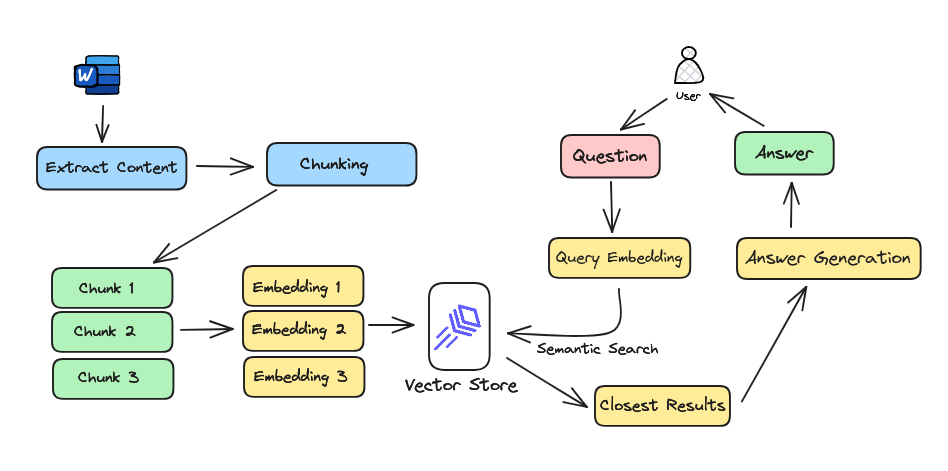

## Install Dependencies

In [ ]:
# Install
!pip install transformers scikit-learn docx2txt datasets nltk lancedb openai==0.28 -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.4 MB/s eta 0:00:00


### Set OPENAI API KEY as env variable

In [ ]:
# Set OPENAI_API_KEY

import os
os.environ["OPENAI_API_KEY"] = "sk-..."

## Data Loading

In [ ]:
# Load text

# !wget link
with open("lease.txt", "r") as file:
    text_data = file.read()

## Data Chunking and Embedding

In [ ]:
# Recursive Text Splitter

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import re

def recursive_text_splitter(text, max_chunk_length=1000, overlap=100):
    """
    Helper function for chunking text recursively
    """
    # Initialize result
    result = []

    current_chunk_count = 0
    separator = ["\n", " "]
    _splits = re.split(f"({separator})", text)
    splits = [_splits[i] + _splits[i + 1] for i in range(1, len(_splits), 2)]

    for i in range(len(splits)):
        if current_chunk_count != 0:
            chunk = "".join(splits[current_chunk_count-overlap: current_chunk_count+max_chunk_length])
        else:
            chunk = "".join(splits[0:max_chunk_length])

        if len(chunk)>0:
            result.append("".join(chunk))
        current_chunk_count+= max_chunk_length

    return result


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Split the text using the recursive character text splitter
chunks = recursive_text_splitter(text_data, max_chunk_length=100, overlap=10)
print("Number of Chunks: ", len(chunks))

Number of Chunks:  11


### Embedder

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Choose a pre-trained model (e.g., BERT, RoBERTa, etc.)
# Load the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def embedder(chunk):
    """
    Helper function to embed chunk of text
    """
    # Tokenize the input text
    tokens = tokenizer(chunk, return_tensors="pt", padding=True, truncation=True)

    # Get the model's output (including embeddings)
    with torch.no_grad():
        model_output = model(**tokens)

    # Extract the embeddings
    embeddings = model_output.last_hidden_state[:, 0, :]
    embed = embeddings[0].numpy()
    return embed

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Embed all the chunks of text
embeds = []
for chunk in chunks:
    embed = embedder(chunks)
    embeds.append(embed)

## Vector Store

In [ ]:
# Insert text chunks with their embeddings

import lancedb

def prepare_data(chunks, embeddings):
    """
    Helper function to prepare data to insert in LanceDB
    """
    data = []
    for chunk, embed in zip(chunks, embeddings):
        temp = {}
        temp['text'] = chunk
        temp['vector'] = embed
        data.append(temp)
    return data


def lanceDBConnection(chunks, embeddings):
    """
    LanceDB insertion
    """
    db = lancedb.connect("/tmp/lancedb")
    data = prepare_data(chunks, embeddings)
    table = db.create_table(
        "scratch",
        data=data,
        mode="overwrite",)
    return table

table = lanceDBConnection(chunks, embeds)

## Retriever & Prompt preparation

In [ ]:
# Retriever
k = 5
question = 'What is issue date of lease?'

# Embed Question
query_embedding = embedder(question)
# Semantic Search
result = table.search(query_embedding).limit(5).to_list()

In [ ]:
context = [r['text'] for r in result]
context

[' 2 elmonteleaseforfiling.htm MATERIAL CONTRACT\nCOMMERCIAL LEASE AGREEMENT\n\n\n\nTHIS LEASE AGREEMENT is made and entered into on December 1, 2013, by and between Temple CB, LLC, whose address is 4350 Temple City Boulevard, El Monte, California 91731 (hereinafter referred to as "Landlord"), and Okra Energy, Inc., whose address is 4350 Temple City Boulevard, El Monte, California 91731 (hereinafter referred to as "Tenant").\n\n\n\nARTICLE I - GRANT OF LEASE\n\n\n\nLandlord, in consideration of the rents to be paid and the covenants',
 ' consideration of the rents to be paid and the covenants and agreements to be performed and observed by the Tenant, does hereby lease to the Tenant and the Tenant does hereby lease and take from the Landlord the property described in Exhibit "A" attached hereto and by reference made a part hereof (the "Leased Premises"), together with, as part of the parcel, all improvements located thereon.\n\n\n\nARTICLE II - LEASE TERM\n\n\n\nSection l.  Term of Leas

In [ ]:
# Context Prompt

base_prompt = """You are an AI assistant. Your task is to understand the user question, and provide an answer using the provided contexts. Every answer you generate should have citations in this pattern  "Answer [position].", for example: "Earth is round [1][2].," if it's relevant.

Your answers are correct, high-quality, and written by an domain expert. If the provided context does not contain the answer, simply state, "The provided context does not have the answer."

User question: {}

Contexts:
{}
"""


## Answer Generation

In [ ]:
import openai

# llm
prompt = f'{base_prompt.format(question, context)}'
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-16k-0613",
    temperature=0,
    messages=[
        {"role": "system", "content": prompt},
    ]
)

print(response.choices[0].message.content)

The issue date of the lease is December 1, 2013 [1].
